<a href="https://colab.research.google.com/github/chunjie-sam-liu/TEP-prognosis/blob/main/analysis/08_AESurv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
! pip install torchtuples
! pip install pycox
! pip install hiddenlayer

In [28]:
import numpy as np
import feather
import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.modules.linear import Linear
import torchtuples as tt

from pycox.models import LogisticHazard
from pycox.models.loss import NLLLogistiHazardLoss
from pycox.evaluation import EvalSurv

import os

In [29]:
# random
np.random.seed(1234)
_ = torch.manual_seed(1234)

In [30]:
class NetAESurv(nn.Module):
    def __init__(self, in_features, encoded_features, out_features):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(in_features, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, encoded_features),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoded_features, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, in_features),
        )

        # Full connection
        self.survnet = nn.Sequential(
            nn.Linear(encoded_features, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, out_features),
        )

    def forward(self, input):
        encoded = self.encoder(input)
        decoded = self.decoder(encoded)
        phi = self.survnet(encoded)
        return phi, decoded

    def predict(self, input):
        encoded = self.encoder(input)
        return self.survnet(encoded)


In [31]:
class LossAELogHaz(nn.Module):
    def __init__(self, alpha):
        super().__init__()
        assert (alpha >= 0) and (alpha <= 1), "Need `alpha` in [0, 1]."
        self.alpha = alpha
        self.loss_surv = NLLLogistiHazardLoss()
        self.loss_ae = nn.MSELoss()

    def forward(self, phi, decoded, target_loghaz, target_ae):
        idx_durations, events = target_loghaz
        loss_surv = self.loss_surv(phi, idx_durations, events)
        loss_ae = self.loss_ae(decoded, target_ae)
        print(decoded.shape)
        print(target_ae.shape)
        return self.alpha * loss_surv + (1 - self.alpha) * loss_ae


In [32]:
def load_data(filepath):
    df = feather.read_dataframe(source=filepath)
    df_train = df.loc[df.oc == "OC521"].drop(columns=["barcode", "oc"], axis=1)
    df_val = df.loc[df.oc == "OC44"].drop(columns=["barcode", "oc"], axis=1)
    df_test1 = df.loc[df.oc == "OC79"].drop(columns=["barcode", "oc"], axis=1)
    df_test2 = df.loc[df.oc == "OC172"].drop(columns=["barcode", "oc"], axis=1)
    return df_train, df_val, df_test1, df_test2


def get_target(df):
    return (df["duration"].values, df["event"].values)


def transform_features(df_train, df_val, df_test1, df_test2):
    columns = df_train.columns
    columns = columns[: len(columns) - 2]
    standardize = [([col], StandardScaler()) for col in columns]

    x_mapper = DataFrameMapper(standardize)

    x_train = x_mapper.fit_transform(df_train).astype("float32")
    x_val = x_mapper.transform(df_val).astype("float32")
    x_test1 = x_mapper.transform(df_test1).astype("float32")
    x_test2 = x_mapper.transform(df_test2).astype("float32")

    return x_train, x_val, x_test1, x_test2


def transform_labels(df_train, df_val, nd=10):
    num_durations = nd
    labtrans = LogisticHazard.label_transform(num_durations)
    y_train_surv = labtrans.fit_transform(*get_target(df_train))
    y_val_surv = labtrans.transform(*get_target(df_val))

    return y_train_surv, y_val_surv, labtrans


In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
filepath="/content/drive/MyDrive/colab-data/total416.os.se.norm.coxph.feather"

In [35]:
# load data
df_train, df_val, df_test1, df_test2 = load_data(filepath)
# transform features
x_train, x_val, x_test1, x_test2 = transform_features(df_train, df_val, df_test1, df_test2)
# transform labels
y_train_surv, y_val_surv, labtrans = transform_labels(df_train, df_val)

In [36]:
print(x_train.shape, x_val.shape, x_test1.shape, x_test2.shape, sep = '\n')
print(y_train_surv)

(277, 409)
(20, 409)
(37, 409)
(82, 409)
(array([1, 3, 1, 3, 3, 1, 2, 3, 3, 2, 3, 5, 6, 4, 3, 4, 5, 3, 3, 2, 6, 3,
       3, 6, 3, 2, 3, 3, 3, 3, 9, 6, 3, 2, 2, 3, 3, 3, 1, 9, 5, 4, 3, 3,
       3, 4, 7, 2, 2, 1, 3, 7, 2, 2, 3, 8, 3, 5, 3, 4, 2, 3, 1, 2, 4, 3,
       3, 4, 2, 3, 6, 4, 3, 3, 8, 7, 1, 5, 2, 3, 2, 4, 3, 1, 3, 5, 6, 2,
       2, 7, 5, 3, 6, 2, 1, 1, 1, 3, 3, 7, 2, 5, 6, 5, 7, 1, 2, 6, 2, 6,
       2, 7, 2, 2, 2, 2, 2, 6, 5, 5, 3, 3, 3, 6, 3, 2, 2, 1, 2, 2, 2, 2,
       3, 2, 7, 2, 2, 5, 5, 2, 5, 3, 9, 5, 2, 6, 9, 1, 1, 1, 2, 2, 3, 3,
       4, 3, 2, 3, 8, 2, 2, 1, 3, 1, 6, 3, 3, 9, 2, 5, 3, 6, 4, 4, 1, 1,
       3, 3, 2, 2, 6, 9, 3, 3, 0, 1, 9, 4, 5, 2, 3, 3, 3, 3, 3, 3, 3, 5,
       3, 2, 2, 1, 9, 2, 6, 9, 3, 3, 2, 2, 4, 3, 4, 3, 2, 9, 2, 6, 5, 2,
       2, 3, 2, 2, 2, 3, 3, 3, 3, 4, 2, 3, 3, 2, 9, 3, 4, 4, 4, 7, 3, 3,
       3, 4, 2, 3, 6, 2, 3, 1, 2, 1, 2, 2, 2, 3, 4, 3, 9, 8, 3, 3, 3, 3,
       4, 3, 2, 9, 2, 3, 3, 5, 5, 3, 3, 2, 7]), array([1., 0., 1., 0., 0., 1., 1.,

In [37]:
df_train.head()

,ENSG00000084093,ENSG00000086506,ENSG00000101888,ENSG00000110090,ENSG00000128699,ENSG00000134375,ENSG00000139211,ENSG00000141503,ENSG00000143033,ENSG00000143851,ENSG00000156931,ENSG00000163536,ENSG00000165511,ENSG00000166783,ENSG00000166974,ENSG00000180233,ENSG00000184924,ENSG00000185905,ENSG00000189045,ENSG00000206503,ENSG00000223478,ENSG00000259758,ENSG00000260912,ENSG00000033800,ENSG00000065882,ENSG00000071189,ENSG00000077420,ENSG00000084112,ENSG00000090316,ENSG00000102897,ENSG00000105939,ENSG00000106245,ENSG00000109320,ENSG00000109790,ENSG00000112062,ENSG00000125347,ENSG00000127603,ENSG00000132963,ENSG00000134419,ENSG00000138185,...,ENSG00000064961,ENSG00000066697,ENSG00000067955,ENSG00000068831,ENSG00000075945,ENSG00000077235,ENSG00000092330,ENSG00000102144,ENSG00000109736,ENSG00000122068,ENSG00000140740,ENSG00000141741,ENSG00000146278,ENSG00000154174,ENSG00000161202,ENSG00000168288,ENSG00000185885,ENSG00000188536,ENSG00000196655,ENSG00000008294,ENSG00000020633,ENSG00000068878,ENSG00000106537,ENSG00000107854,ENSG00000109756,ENSG00000111913,ENSG00000127533,ENSG00000131507,ENSG00000153162,ENSG00000156482,ENSG00000159593,ENSG00000163947,ENSG00000168887,ENSG00000169738,ENSG00000176659,ENSG00000180871,ENSG00000198218,ENSG00000206341,event,duration
0,6.879163,8.458715,8.141162,8.477021,7.088964,5.129439,7.958826,10.533317,6.747580,6.477264,9.869379,5.981795,4.350759,8.480397,11.953209,6.265971,4.585179,6.174713,5.767146,13.632956,6.673255,7.123836,8.925594,7.228695,9.604599,6.070729,7.385854,9.335593,6.246735,8.677107,8.798896,7.358652,6.415272,8.428815,9.047465,7.128213,9.681933,8.625243,5.922117,5.164845,...,10.866993,8.874066,6.344298,11.744162,9.544671,5.933776,7.984798,11.726939,6.054949,8.834316,7.719415,5.653050,7.616582,5.887446,6.874007,6.571465,6.773154,13.350180,5.870364,5.800653,6.933065,8.278672,9.288598,6.890412,5.044198,10.259959,8.636226,10.334818,10.090550,6.314396,8.634257,7.886480,9.555820,4.902696,4.815511,7.626230,5.978092,5.612674,1.0,7.0
1,6.977793,7.844120,7.902081,8.715474,7.375811,5.685850,8.388649,10.685548,6.001948,6.250326,9.976833,7.104327,4.776515,8.162742,11.554780,6.112250,5.194592,7.062255,5.751707,14.457123,6.776814,6.765435,9.618390,7.931196,8.719096,5.838488,7.082992,9.317770,7.044638,8.551956,8.548779,7.243116,6.416988,10.325015,9.227702,8.540099,10.035049,8.767634,5.472116,6.082655,...,11.151241,9.699310,6.183216,11.443309,9.175647,5.612944,7.897401,12.003104,6.936134,8.093545,7.583967,5.416261,7.246122,5.471855,6.437359,7.021050,6.007571,14.779288,5.974117,5.846142,6.749413,7.684153,9.107700,5.767089,5.833599,10.261924,9.009353,10.096237,11.013922,5.968971,8.153609,8.644792,9.714069,5.240695,4.222700,6.232203,6.518276,4.680726,0.0,37.0
2,7.302059,9.907713,8.616968,9.352266,7.068370,4.865470,7.958650,10.447766,6.529168,6.829614,9.616442,7.004844,5.094179,8.037981,11.782325,7.055009,4.694215,5.633643,5.312495,14.479091,6.009910,6.944611,9.000986,7.339479,9.142980,6.317678,7.291850,9.578727,6.919642,8.801744,8.659556,6.890518,6.319749,9.517712,8.745434,7.255194,9.630995,8.657274,5.491109,5.588486,...,10.227864,9.057432,6.387286,12.017450,9.791649,5.778146,7.933420,11.810795,6.087445,8.674996,7.643286,5.466266,7.572475,5.235920,6.847069,6.349485,6.110018,14.059286,5.798608,5.841076,7.420809,8.255132,8.502862,6.659868,5.666866,10.613283,8.676550,10.891044,10.903838,5.791671,8.845572,9.554941,9.748692,5.201944,5.408351,7.786217,5.900832,8.080117,1.0,7.0
3,6.949325,7.781480,8.409461,9.977516,7.426219,4.403145,8.249846,9.789865,5.881410,6.370855,8.868285,7.003866,4.652993,7.992677,12.129287,6.596019,4.337818,5.847877,4.851487,14.980533,6.369123,6.957447,9.571293,7.746914,8.102428,6.035582,7.921720,9.247298,7.058743,8.479040,8.258099,7.276499,6.006603,7.961725,9.227048,8.135073,9.692071,8.086847,6.066195,5.058931,...,10.953318,9.357304,5.609171,11.919643,10.183914,5.651885,8.107601,12.292880,6.594543,7.914871,7.974290,5.560301,7.448070,5.871822,6.926275,6.893469,6.759016,13.525395,6.575294,6.06649

In [38]:
df_val.head()

,ENSG00000084093,ENSG00000086506,ENSG00000101888,ENSG00000110090,ENSG00000128699,ENSG00000134375,ENSG00000139211,ENSG00000141503,ENSG00000143033,ENSG00000143851,ENSG00000156931,ENSG00000163536,ENSG00000165511,ENSG00000166783,ENSG00000166974,ENSG00000180233,ENSG00000184924,ENSG00000185905,ENSG00000189045,ENSG00000206503,ENSG00000223478,ENSG00000259758,ENSG00000260912,ENSG00000033800,ENSG00000065882,ENSG00000071189,ENSG00000077420,ENSG00000084112,ENSG00000090316,ENSG00000102897,ENSG00000105939,ENSG00000106245,ENSG00000109320,ENSG00000109790,ENSG00000112062,ENSG00000125347,ENSG00000127603,ENSG00000132963,ENSG00000134419,ENSG00000138185,...,ENSG00000064961,ENSG00000066697,ENSG00000067955,ENSG00000068831,ENSG00000075945,ENSG00000077235,ENSG00000092330,ENSG00000102144,ENSG00000109736,ENSG00000122068,ENSG00000140740,ENSG00000141741,ENSG00000146278,ENSG00000154174,ENSG00000161202,ENSG00000168288,ENSG00000185885,ENSG00000188536,ENSG00000196655,ENSG00000008294,ENSG00000020633,ENSG00000068878,ENSG00000106537,ENSG00000107854,ENSG00000109756,ENSG00000111913,ENSG00000127533,ENSG00000131507,ENSG00000153162,ENSG00000156482,ENSG00000159593,ENSG00000163947,ENSG00000168887,ENSG00000169738,ENSG00000176659,ENSG00000180871,ENSG00000198218,ENSG00000206341,event,duration
26,7.043671,7.876067,8.411803,9.208748,7.543860,5.074943,8.056235,10.269842,5.881782,6.487038,9.920924,7.168252,3.384119,8.159472,12.007499,6.952222,4.547143,6.301505,5.438728,14.039512,6.768899,6.798084,8.531835,7.745610,9.660739,6.056743,8.094003,8.877764,6.220604,8.434402,8.543914,7.334315,5.850030,10.134004,9.387552,7.378172,9.563097,8.359034,6.411055,6.398021,...,10.244473,9.318543,6.538290,11.564538,9.479197,6.468504,7.581745,11.727399,6.725116,8.710526,7.414869,5.525628,7.204235,5.514955,6.360058,6.423866,4.907475,14.776143,6.110889,5.330108,7.761963,8.246927,8.258626,5.599304,5.393138,10.530405,8.791271,8.928028,10.968118,6.593707,9.224524,8.826462,9.737916,5.947463,5.057503,6.772122,5.528775,6.843511,1.0,45.0
28,7.448648,8.013899,8.425709,8.984744,7.429803,5.422422,8.398632,10.449021,5.937140,6.691511,9.861555,7.062354,4.798118,7.918843,11.911768,6.888721,5.564861,6.781725,5.601471,14.024067,6.000367,7.068272,9.218564,7.240409,9.733834,6.131832,7.153010,9.194954,7.152014,8.990956,8.659387,7.330928,5.998246,8.816686,8.890744,8.628837,9.541405,8.786391,5.838731,6.078205,...,10.683699,9.719044,6.133878,11.602315,9.582980,5.634342,7.968376,11.816854,6.659100,8.471625,7.449322,5.814801,7.528910,5.074068,6.348640,6.713763,4.829137,12.431362,6.729425,5.482643,7.708947,8.577319,9.422731,5.787397,5.566850,10.309256,9.130100,9.899956,10.977949,6.228161,8.738145,8.544032,9.503761,6.309642,5.291326,6.726709,6.154738,6.601644,1.0,21.0
35,7.218642,8.905158,8.177606,9.109810,6.905127,5.054354,8.040717,10.703467,5.645941,6.444789,10.130465,7.346459,5.237126,8.186252,12.147948,6.907664,5.865687,6.029390,4.875613,14.159435,6.697396,7.583392,9.896996,7.355199,8.797257,5.983031,7.719701,9.433206,6.915415,8.528034,9.059935,7.500725,6.114283,8.936413,8.899391,8.434923,10.125650,8.638969,6.196389,6.233854,...,10.746328,9.641171,5.936939,11.656332,9.562371,5.731404,8.009192,11.554647,6.679073,8.886018,7.936027,5.598829,7.236849,4.770164,6.808705,6.842515,6.563927,13.520805,5.845789,5.426771,7.728613,8.576290,9.237870,5.569635,5.415338,10.697898,8.828918,10.565017,11.041082,6.508144,8.810583,8.386173,9.551756,5.455049,5.241517,6.811334,6.013463,7.536677,1.0,20.0
52,6.983662,8.406645,8.254910,9.035086,6.991286,5.879770,8.540519,10.519964,6.472831,5.973271,9.674421,7.167711,4.871710,8.305250,11.457253,6.819732,5.597299,6.317065,6.818737,14.299102,6.455256,7.399553,9.613107,7.387402,9.143046,5.959682,7.879016,9.249411,6.731429,8.630207,9.006170,7.461936,6.131174,9.952851,9.115383,8.307642,9.796400,9.040626,5.944822,5.651361,...,11.010921,9.635485,6.473211,11.684627,9.681191,5.704111,7.609140,11.857685,6.548512,8.143519,7.774338,5.738326,7.160514,4.910489,6.220173,6.940598,5.591871,13.232580,6.229879,5.

In [39]:
df_test1.head()

,ENSG00000084093,ENSG00000086506,ENSG00000101888,ENSG00000110090,ENSG00000128699,ENSG00000134375,ENSG00000139211,ENSG00000141503,ENSG00000143033,ENSG00000143851,ENSG00000156931,ENSG00000163536,ENSG00000165511,ENSG00000166783,ENSG00000166974,ENSG00000180233,ENSG00000184924,ENSG00000185905,ENSG00000189045,ENSG00000206503,ENSG00000223478,ENSG00000259758,ENSG00000260912,ENSG00000033800,ENSG00000065882,ENSG00000071189,ENSG00000077420,ENSG00000084112,ENSG00000090316,ENSG00000102897,ENSG00000105939,ENSG00000106245,ENSG00000109320,ENSG00000109790,ENSG00000112062,ENSG00000125347,ENSG00000127603,ENSG00000132963,ENSG00000134419,ENSG00000138185,...,ENSG00000064961,ENSG00000066697,ENSG00000067955,ENSG00000068831,ENSG00000075945,ENSG00000077235,ENSG00000092330,ENSG00000102144,ENSG00000109736,ENSG00000122068,ENSG00000140740,ENSG00000141741,ENSG00000146278,ENSG00000154174,ENSG00000161202,ENSG00000168288,ENSG00000185885,ENSG00000188536,ENSG00000196655,ENSG00000008294,ENSG00000020633,ENSG00000068878,ENSG00000106537,ENSG00000107854,ENSG00000109756,ENSG00000111913,ENSG00000127533,ENSG00000131507,ENSG00000153162,ENSG00000156482,ENSG00000159593,ENSG00000163947,ENSG00000168887,ENSG00000169738,ENSG00000176659,ENSG00000180871,ENSG00000198218,ENSG00000206341,event,duration
32,7.681177,8.917395,8.729681,7.863432,6.457235,3.603980,8.335852,10.378298,7.754120,7.443640,9.670577,6.652265,4.088456,8.025857,11.546236,7.371160,6.254746,7.262991,2.034102,13.844169,6.227668,7.149509,8.765522,4.411511,9.029794,7.764989,7.228815,8.956339,7.106332,8.552318,8.161904,7.856445,6.984669,8.766259,8.979193,8.747281,9.641869,8.561385,6.068118,1.891004,...,10.655285,9.403552,7.773794,11.786845,9.464030,7.495586,8.260568,11.670934,5.304027,8.907348,7.350568,7.079018,8.092581,7.291719,6.557402,6.776596,7.537137,12.182713,5.490572,5.814813,8.239525,7.115278,6.561297,7.298547,6.606000,10.114061,9.135393,9.658226,11.041527,5.468692,8.758179,9.993206,9.510354,5.012015,6.685644,1.625082,6.656929,7.689722,1.0,5.0
63,7.590416,8.007175,8.377366,8.993980,7.194004,5.463743,8.505254,10.512558,5.774852,6.653455,9.544562,7.480212,5.848666,8.030021,12.144268,6.774703,5.485245,6.828915,5.774224,14.950730,6.166855,6.644513,9.808308,7.005870,9.126976,6.579783,7.295950,9.098377,6.751126,8.847997,8.853769,7.443098,5.790981,9.692708,8.691586,8.291677,10.360532,8.448614,5.912648,5.683514,...,10.720248,9.379117,6.598749,11.503305,9.851276,5.410705,8.041513,11.958662,6.752096,8.594336,7.598258,5.552040,7.436485,4.425430,6.760493,6.315953,6.114681,13.621513,6.622483,6.367425,7.271116,8.289596,9.232081,6.248952,5.791032,10.481147,8.835745,10.410920,10.850941,6.145812,8.697897,8.214106,9.083758,5.888867,4.976335,7.266594,6.211068,6.615839,0.0,84.0
66,6.365835,8.014019,7.637490,9.527242,7.030709,3.850183,8.138850,10.292661,6.517411,6.349291,9.889343,6.519152,5.629521,7.462755,12.247071,6.594736,3.693114,5.780456,6.198670,14.207866,6.230055,7.885491,9.456437,7.187856,9.295761,6.326284,7.362192,9.232608,7.097590,8.491082,9.137358,7.504312,6.224510,8.656488,9.428549,7.372640,9.896258,9.127241,6.571960,5.865852,...,10.623166,9.335676,5.993408,11.476128,9.160239,6.147951,7.804287,11.239232,6.803441,8.768229,7.897546,5.372640,7.856456,5.585527,6.698219,6.067031,6.772729,13.299542,6.631662,5.483849,6.898876,7.995777,9.671966,5.409826,5.403593,10.563089,9.016878,7.315922,10.796868,6.783822,7.723659,8.774364,9.397303,5.684307,5.265000,7.878291,6.503806,6.974432,1.0,32.0
67,7.529325,7.546180,7.939112,8.529685,7.496775,5.077163,8.526424,10.550879,5.885743,6.418116,10.028750,6.231692,4.890189,8.069687,12.134658,7.358599,4.730322,6.619777,5.930547,14.309506,6.192666,6.944455,9.290084,7.441353,8.881077,5.962964,7.289075,9.016079,6.664604,8.618519,8.716634,7.231071,6.491850,9.403110,9.443491,7.987085,10.100965,8.523654,6.418726,6.172854,...,10.825948,9.744901,6.550008,11.181235,9.277143,6.370628,8.274265,11.915095,6.694216,8.524635,7.572614,5.407727,7.568547,4.517491,6.077238,6.427405,6.127210,12.870686,6.058397,5.7

In [40]:
df_test2.head()

,ENSG00000084093,ENSG00000086506,ENSG00000101888,ENSG00000110090,ENSG00000128699,ENSG00000134375,ENSG00000139211,ENSG00000141503,ENSG00000143033,ENSG00000143851,ENSG00000156931,ENSG00000163536,ENSG00000165511,ENSG00000166783,ENSG00000166974,ENSG00000180233,ENSG00000184924,ENSG00000185905,ENSG00000189045,ENSG00000206503,ENSG00000223478,ENSG00000259758,ENSG00000260912,ENSG00000033800,ENSG00000065882,ENSG00000071189,ENSG00000077420,ENSG00000084112,ENSG00000090316,ENSG00000102897,ENSG00000105939,ENSG00000106245,ENSG00000109320,ENSG00000109790,ENSG00000112062,ENSG00000125347,ENSG00000127603,ENSG00000132963,ENSG00000134419,ENSG00000138185,...,ENSG00000064961,ENSG00000066697,ENSG00000067955,ENSG00000068831,ENSG00000075945,ENSG00000077235,ENSG00000092330,ENSG00000102144,ENSG00000109736,ENSG00000122068,ENSG00000140740,ENSG00000141741,ENSG00000146278,ENSG00000154174,ENSG00000161202,ENSG00000168288,ENSG00000185885,ENSG00000188536,ENSG00000196655,ENSG00000008294,ENSG00000020633,ENSG00000068878,ENSG00000106537,ENSG00000107854,ENSG00000109756,ENSG00000111913,ENSG00000127533,ENSG00000131507,ENSG00000153162,ENSG00000156482,ENSG00000159593,ENSG00000163947,ENSG00000168887,ENSG00000169738,ENSG00000176659,ENSG00000180871,ENSG00000198218,ENSG00000206341,event,duration
328,7.407136,8.209015,7.887349,9.194391,7.165570,4.884930,8.400290,10.377176,6.223285,6.454221,9.883807,7.363066,4.700130,8.007447,11.940402,7.396149,5.242995,7.117985,5.777991,13.829622,6.357120,6.994057,9.727660,7.583806,8.746818,6.244640,7.872063,8.962915,6.776079,8.692620,9.125645,6.973685,6.578003,9.622198,9.225908,8.105023,10.087097,8.398395,6.203337,5.378526,...,10.366109,9.387245,6.204481,11.353256,9.530100,5.538467,8.169675,11.803563,6.984826,8.561782,7.820451,5.900529,7.433330,5.200910,6.852247,6.763278,6.252039,13.940525,6.175388,5.813283,7.301913,8.201510,9.665413,5.565680,6.239187,10.778769,9.372690,9.900819,11.000396,6.192725,8.825487,8.649624,9.570360,5.590093,5.129194,7.556309,6.396531,5.761320,0.0,18.0
329,7.576514,8.037716,7.874452,8.502273,7.276658,6.236889,8.343391,10.034027,5.686322,6.611386,9.528696,7.526491,5.883230,7.606531,12.051499,6.990922,4.995255,6.670266,5.448525,14.167995,6.526665,7.503515,9.087165,7.222954,8.757433,6.074732,7.107449,8.945954,6.333572,8.820038,8.931195,7.045908,6.203675,10.270130,9.606976,8.234344,10.287135,8.568859,5.715626,5.829762,...,10.843063,9.435896,6.778356,11.647120,9.412718,6.344063,7.689442,11.929056,6.773859,8.517432,7.293260,5.592956,7.592395,4.872925,6.890139,6.446449,6.078776,15.554058,6.204118,5.844793,8.065789,8.331307,7.659415,6.270597,5.490168,10.332835,9.075306,9.239657,10.998645,7.366857,8.379505,9.128629,9.902227,5.594727,5.996622,5.907459,6.328001,7.696725,0.0,30.0
330,7.291415,7.980210,8.151760,9.130138,7.031829,5.397617,8.102924,10.389005,5.998184,6.497955,9.839571,8.096338,4.694879,7.891570,12.417387,7.027768,5.294682,6.434245,5.471086,14.026858,6.279437,7.435961,9.492857,7.263341,8.489471,6.119654,6.767373,9.153812,6.431484,8.683571,8.578737,7.256351,6.146718,9.572132,8.812533,8.686800,9.905543,8.642776,6.282511,5.920779,...,11.165076,9.562806,6.769112,11.718989,8.921813,6.219948,7.462693,11.834176,6.072250,8.155123,7.490467,5.603554,7.770507,5.810692,6.510501,6.266021,6.316235,13.852826,6.880766,6.075073,7.718585,8.342862,9.395419,6.002283,6.122245,10.521045,8.786832,10.745086,11.022659,6.776739,8.149559,7.789925,9.079882,5.979312,5.694862,6.602405,6.264121,6.373102,1.0,36.0
331,7.687569,7.254277,8.239024,9.214660,7.453210,5.209331,8.212660,10.564443,6.229061,6.746995,10.229730,7.455092,4.286954,8.354663,11.566661,6.860878,5.114714,6.495022,6.549925,14.210949,6.152275,7.854277,9.156246,7.338054,8.445300,6.628732,7.023121,8.999968,6.534954,8.774687,8.709720,7.403948,5.198209,10.653589,9.430018,7.026047,10.244672,8.483669,5.566042,5.961177,...,10.774087,9.232950,7.123009,11.147078,9.526956,6.294278,8.114306,11.961341,6.805379,8.378615,7.690031,5.716684,7.391889,5.744805,6.241698,6.716306,6.189411,14.689214,6.07

(array([ 1., 24., 70., 93., 22., 21., 19., 10.,  4., 13.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

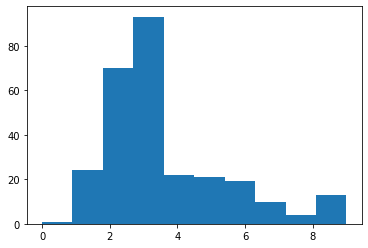

In [41]:
plt.hist(y_train_surv[0])

In [42]:
# make train and validation datasets with tuplefy
train = tt.tuplefy(x_train, (y_train_surv, x_train))
val = tt.tuplefy(x_val, (y_val_surv, x_val))

In [43]:
durations_test1, events_test1 = get_target(df_test1)
durations_test2, events_test2 = get_target(df_test2)

In [44]:
# set arch
in_features = x_train.shape[1]
encoded_features = 64
out_features = labtrans.out_features
netaesurv = NetAESurv(in_features, encoded_features, out_features)

In [45]:
netaesurv

NetAESurv(
  (encoder): Sequential(
    (0): Linear(in_features=409, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=2048, bias=True)
    (9): ReLU()
    (10): Linear(in_features=2048, out_features=409, bias=True)
  )
  (survnet): Sequen

In [46]:
from torchsummary import summary
summary(model=netaesurv, input_size=(1, in_features))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 2048]         839,680
              ReLU-2              [-1, 1, 2048]               0
            Linear-3              [-1, 1, 1024]       2,098,176
              ReLU-4              [-1, 1, 1024]               0
            Linear-5               [-1, 1, 512]         524,800
              ReLU-6               [-1, 1, 512]               0
            Linear-7               [-1, 1, 256]         131,328
              ReLU-8               [-1, 1, 256]               0
            Linear-9               [-1, 1, 128]          32,896
             ReLU-10               [-1, 1, 128]               0
           Linear-11                [-1, 1, 64]           8,256
           Linear-12               [-1, 1, 128]           8,320
             ReLU-13               [-1, 1, 128]               0
           Linear-14               [-1,

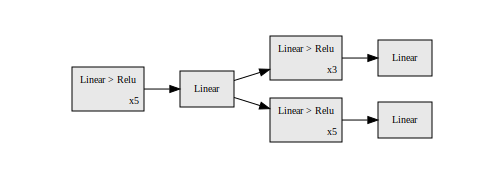

In [47]:
import hiddenlayer as hl
hl.build_graph(netaesurv, torch.zeros([1, in_features]))

In [48]:
# loss
loss = LossAELogHaz(0.6)

In [49]:
loss

LossAELogHaz(
  (loss_surv): NLLLogistiHazardLoss()
  (loss_ae): MSELoss()
)

In [50]:
print(labtrans.cuts)

[  0.          11.11111111  22.22222222  33.33333333  44.44444444
  55.55555556  66.66666667  77.77777778  88.88888889 100.        ]


In [51]:
# model
model = LogisticHazard(net=netaesurv, optimizer=tt.optim.Adam(0.01), duration_index=labtrans.cuts, loss=loss)

In [52]:
dl = model.make_dataloader(train, batch_size=5, shuffle=False)
batch = next(iter(dl))

In [53]:
batch.shapes()

(torch.Size([5, 409]),
 ((torch.Size([5]), torch.Size([5])), torch.Size([5, 409])))

In [54]:
model.compute_metrics(batch)

torch.Size([5, 409])
torch.Size([5, 409])


{'loss': tensor(1.6384, grad_fn=<AddBackward0>)}

In [55]:
model.score_in_batches(*train)

torch.Size([277, 409])
torch.Size([277, 409])


{'loss': 2.25459623336792}

In [56]:
# metrics
metrics = dict(loss_surv=LossAELogHaz(1), loss_ae=LossAELogHaz(0))

# callbacks
callbacks = [tt.cb.EarlyStopping()]

# cycling
batch_size = 5
epochs = 100

# trainning model
log = model.fit(
    *train, batch_size=batch_size, epochs=epochs,  verbose=True, val_data=val, metrics=metrics
)

Streaming output truncated to the last 5000 lines.
torch.Size([5, 409])
torch.Size([5, 409])
torch.Size([5, 409])
torch.Size([5, 409])
torch.Size([5, 409])
torch.Size([5, 409])
torch.Size([5, 409])
torch.Size([5, 409])
torch.Size([5, 409])
torch.Size([5, 409])
torch.Size([5, 409])
torch.Size([5, 409])
torch.Size([5, 409])
torch.Size([5, 409])
torch.Size([5, 409])
torch.Size([5, 409])
torch.Size([5, 409])
torch.Size([5, 409])
torch.Size([5, 409])
torch.Size([5, 409])
torch.Size([5, 409])
torch.Size([5, 409])
torch.Size([5, 409])
torch.Size([5, 409])
torch.Size([5, 409])
torch.Size([5, 409])
torch.Size([5, 409])
torch.Size([5, 409])
torch.Size([5, 409])
torch.Size([5, 409])
torch.Size([5, 409])
torch.Size([5, 409])
torch.Size([5, 409])
torch.Size([5, 409])
torch.Size([5, 409])
torch.Size([5, 409])
torch.Size([5, 409])
torch.Size([5, 409])
torch.Size([5, 409])
torch.Size([5, 409])
torch.Size([5, 409])
torch.Size([5, 409])
torch.Size([5, 409])
torch.Size([5, 409])
torch.Size([5, 409])
torc

In [57]:
res = model.log.to_pandas()

In [58]:
res.head(10)

,train_loss,train_loss_surv,train_loss_ae,val_loss,val_loss_surv,val_loss_ae
0,35.159788,1.645404,85.431365,1.698637,1.554065,1.915495
1,1.387169,1.332167,1.469672,1.292030,1.598816,0.831849
2,1.253306,1.358374,1.095703,1.348200,1.697597,0.824105
3,1.179003,1.295871,1.003700,1.275109,1.575320,0.824791
4,1.169177,1.279395,1.003849,1.243429,1.521519,0.826293
5,1.171950,1.289216,0.996051,1.266430,1.561980,0.823106
6,1.190780,1.295778,1.033282,1.247386,1.529839,0.823706
7,1.177456,1.294925,1.001252,1.256011,1.541487,0.827795
8,1.172553,1.288829,0.998139,1.256613,1.546524,0.821748
9,1.196849,1.323717,1.006546,1.251241,1.537769,0.821450


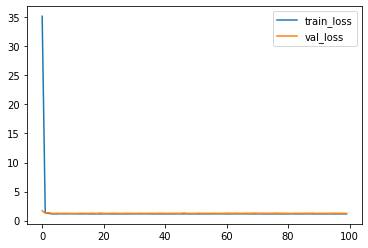

In [59]:
_ = res[['train_loss', 'val_loss']].plot()

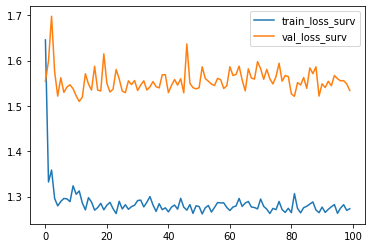

In [60]:
_ = res[['train_loss_surv', 'val_loss_surv']].plot()

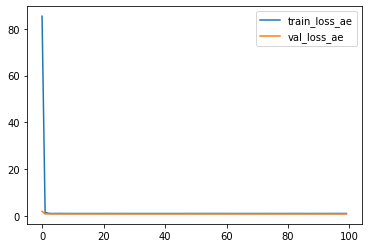

In [61]:
_ = res[['train_loss_ae', 'val_loss_ae']].plot()

                   0         1         2         3         4
0.000000    0.991882  0.991882  0.991882  0.991882  0.991882
1.111111    0.981992  0.981992  0.981992  0.981992  0.981992
2.222222    0.972102  0.972102  0.972102  0.972102  0.972102
3.333333    0.962212  0.962212  0.962212  0.962212  0.962212
4.444444    0.952322  0.952322  0.952322  0.952322  0.952322
...              ...       ...       ...       ...       ...
95.555556   0.150676  0.150676  0.150676  0.150676  0.150676
96.666667   0.142442  0.142442  0.142442  0.142442  0.142442
97.777778   0.134207  0.134207  0.134207  0.134207  0.134207
98.888889   0.125973  0.125973  0.125973  0.125973  0.125973
100.000000  0.117738  0.117738  0.117738  0.117738  0.117738

[91 rows x 5 columns] 


0.506437125748503


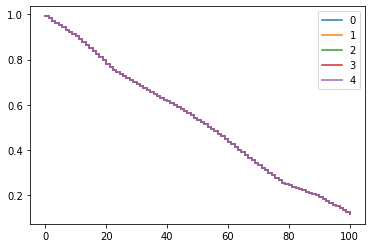

In [62]:
train_surv_df = model.interpolate(10).predict_surv_df(x_train)
print(train_surv_df.iloc[:, :5], '\n\n')
train_durations, train_events = get_target(df_train)
ev_train = EvalSurv(train_surv_df, train_durations, train_events)
print(ev_train.concordance_td())
train_surv_df.iloc[:, :5].plot(drawstyle='steps-post')

                   0         1         2         3         4
0.000000    0.991882  0.991882  0.991882  0.991882  0.991882
1.111111    0.981992  0.981992  0.981992  0.981992  0.981992
2.222222    0.972102  0.972102  0.972102  0.972102  0.972102
3.333333    0.962212  0.962212  0.962212  0.962212  0.962212
4.444444    0.952322  0.952322  0.952322  0.952322  0.952322
...              ...       ...       ...       ...       ...
95.555556   0.150676  0.150676  0.150676  0.150676  0.150676
96.666667   0.142442  0.142442  0.142442  0.142442  0.142442
97.777778   0.134207  0.134207  0.134207  0.134207  0.134207
98.888889   0.125973  0.125973  0.125973  0.125973  0.125973
100.000000  0.117738  0.117738  0.117738  0.117738  0.117738

[91 rows x 5 columns] 


0.5


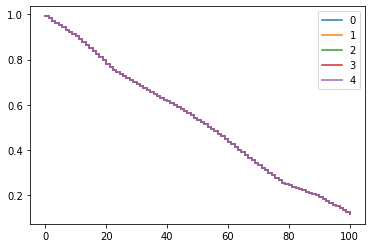

In [63]:
val_surv_df = model.interpolate(10).predict_surv_df(x_val)
print(val_surv_df.iloc[:, :5], '\n\n')
val_durations, val_events = get_target(df_val)
ev_val = EvalSurv(val_surv_df, val_durations, val_events)
print(ev_val.concordance_td())
val_surv_df.iloc[:, :5].plot(drawstyle='steps-post')

In [64]:
surv1 = model.interpolate(10).predict_surv_df(x_test1)
surv2 = model.interpolate(10).predict_surv_df(x_test2)

In [65]:
surv1.iloc[:, :5]

,0,1,2,3,4
0.000000,0.991882,0.991882,0.991882,0.991882,0.991882
1.111111,0.981992,0.981992,0.981992,0.981992,0.981992
2.222222,0.972102,0.972102,0.972102,0.972102,0.972102
3.333333,0.962212,0.962212,0.962212,0.962212,0.962212
4.444444,0.952322,0.952322,0.952322,0.952322,0.952322
...,...,...,...,...,...
95.555556,0.150676,0.150676,0.150676,0.150676,0.150676
96.666667,0.142442,0.142442,0.142442,0.142442,0.142442
97.777778,0.134207,0.134207,0.134207,0.134207,0.134207
98.888889,0.125973,0.125973,0.125973,0.125973,0.125973


In [66]:
surv2.iloc[:, :10]

,0,1,2,3,4,5,6,7,8,9
0.000000,0.991882,0.991882,0.991882,0.991882,0.991882,0.991882,0.991882,0.991882,0.991882,0.991882
1.111111,0.981992,0.981992,0.981992,0.981992,0.981992,0.981992,0.981992,0.981992,0.981992,0.981992
2.222222,0.972102,0.972102,0.972102,0.972102,0.972102,0.972102,0.972102,0.972102,0.972102,0.972102
3.333333,0.962212,0.962212,0.962212,0.962212,0.962212,0.962212,0.962212,0.962212,0.962212,0.962212
4.444444,0.952322,0.952322,0.952322,0.952322,0.952322,0.952322,0.952322,0.952322,0.952322,0.952322
...,...,...,...,...,...,...,...,...,...,...
95.555556,0.150676,0.150676,0.150676,0.150676,0.150676,0.150676,0.150676,0.150676,0.150676,0.150676
96.666667,0.142442,0.142442,0.142442,0.142442,0.142442,0.142442,0.142442,0.142442,0.142442,0.142442
97.777778,0.134207,0.134207,0.134207,0.134207,0.134207,0.134207,0.134207,0.134207,0.134207,0.134207
98.888889,0.125973,0.125973,0.125973,0.125973,0.125973,0.125973,0.125973,0.125973,0.125973,0.125973


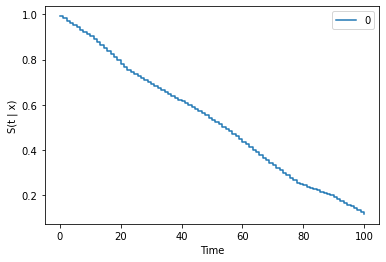

In [67]:
surv1.iloc[:, :1].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

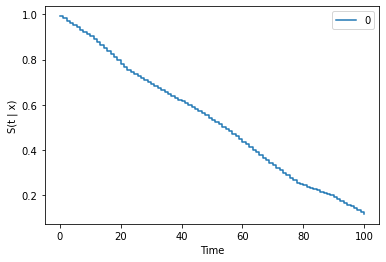

In [68]:
surv2.iloc[:, :1].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [69]:
model.predict(x_test1[:2])

array([[-4.805458  , -2.2004662 , -1.6973565 , -1.9866805 , -1.9869502 ,
        -1.5761988 , -1.1383541 , -0.83207023, -1.2883097 , -0.35755336],
       [-4.805458  , -2.2004662 , -1.6973565 , -1.9866805 , -1.9869502 ,
        -1.5761988 , -1.1383541 , -0.83207023, -1.2883097 , -0.35755336]],
      dtype=float32)

In [70]:
model.predict_net(x_test1[:1])

(array([[-4.805458  , -2.2004662 , -1.6973565 , -1.9866805 , -1.9869502 ,
         -1.5761988 , -1.1383541 , -0.83207023, -1.2883097 , -0.35755336]],
       dtype=float32),
 array([[-9.11742542e-03,  2.29486660e-03, -8.55536107e-03,
         -3.07681598e-03,  8.11120868e-03, -2.13353392e-02,
          6.56292867e-03,  1.01685468e-02,  6.38412777e-04,
         -1.78288762e-03,  1.25361187e-02,  7.86617864e-03,
          5.68920188e-03,  2.27541216e-02,  1.12925228e-02,
         -5.95248304e-03,  2.98921438e-03,  5.37867704e-03,
         -2.14799773e-03, -4.79540974e-03, -1.86694991e-02,
         -1.80409010e-03, -2.23480482e-02,  8.09293799e-03,
         -2.78421286e-02,  2.57664733e-03, -5.41411433e-03,
          3.03936526e-02,  1.69875193e-02,  8.07340024e-04,
         -3.39089474e-03, -7.95073342e-04,  2.63077836e-03,
         -1.54737355e-02, -7.10387900e-03, -1.75781492e-02,
         -2.62186509e-02, -6.02105772e-03, -1.22553091e-02,
         -2.86485162e-02,  1.42614814e-02, -3.5

In [71]:
evs1 = EvalSurv(surv1, durations_test1, events_test1, censor_surv='km')
evs2 = EvalSurv(surv2, durations_test2, events_test2, censor_surv='km')

In [72]:
evs1.concordance_td()

0.5

In [73]:
evs2.concordance_td()

0.508686210640608

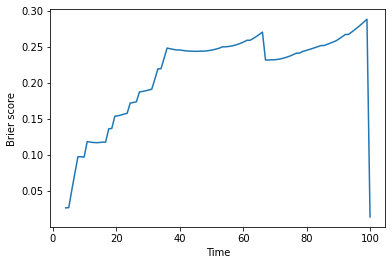

In [74]:
time_grid = np.linspace(durations_test1.min(), durations_test1.max(), 100)
evs1.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

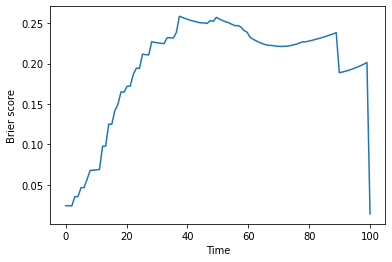

In [75]:
time_grid = np.linspace(durations_test2.min(), durations_test2.max(), 100)
evs2.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

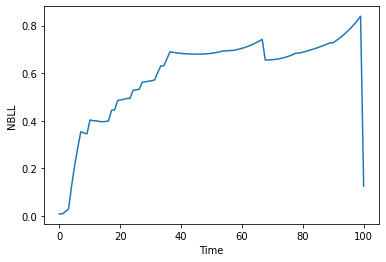

In [76]:
evs1.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

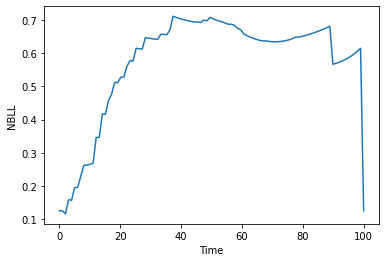

In [77]:
evs2.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

In [78]:
evs1.integrated_brier_score(time_grid)

0.20746719662779067

In [79]:
evs1.integrated_nbll(time_grid)

0.5992454067067723

In [80]:
evs2.integrated_brier_score(time_grid)

0.19770745415529864

In [81]:
evs2.integrated_nbll(time_grid)

0.5764418200918427